In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files, power_spectra

23-10-31 01:03:50   imports.py INF   Setting up healpy to run on 256 CPUs 
23-10-31 01:03:50   imports.py INF   Setting up healpy to run on 256 CPUs 
23-10-31 01:03:50   imports.py INF   Setting up healpy to run on 256 CPUs 


# get map

In [3]:
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v4/grf/tfrecords/grid/DESy3_grid_000.tfrecord"
# params = ["Om", "s8", "Aia", "bg", "n_Aia", "n_bg"]
# filename_suffix = "_grf"
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"

# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v4/large_scales/tfrecords/grid/DESy3_grid_249.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v4/large_scales/tfrecords/grid/DESy3_grid_000.tfrecord"
# params = ["Om", "s8", "Aia", "bg", "n_Aia", "n_bg"]

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/grid/DESy3linear_grid_000.tfrecord"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/grid/DESy3quadratic_grid_000.tfrecord"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/tfrecords/grid/DESy3_grid_000.tfrecord"
# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/debug/DESy3_grid_000.tfrecord"
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v5/linear_bias/tfrecords/grid/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
filename_suffix = "_linear"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/quadratic_bias/debug/DESy3_grid_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/quadratic_bias.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# filename_suffix = "_quadratic"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/stochasticity/tfrecords/grid/DESy3_grid_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/stochasticity.yaml"
# params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "_stochasticity"
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v5/stochasticity/tfrecords/grid/DESy3_grid_000.tfrecord"
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v5/stochasticity.yaml"


In [4]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False
)

23-10-31 01:03:51     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-10-31 01:03:51     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [6]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3

In [7]:
noisy_grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        n_noise=n_noise,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

for dv, cosmo, index in noisy_grid_dset.take(1):
    pass
    
print(dv.shape)

23-10-31 01:07:26 grid_pipelin INF   Interleaving with n_readers = 1 
23-10-31 01:07:26 grid_pipelin INF   Batching into 1 elements locally 
23-10-31 01:07:27 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-10-31 01:07:27 grid_pipelin INF   Running on the data

# evaluate Cls

In [8]:
maps = np.zeros((n_pix, n_z))
maps[data_vec_pix] = dv[0]
alms = power_spectra.get_alms(maps)

l_mins = [30, 30, 30, 30] + [30, 30, 30, 30]
l_maxs = [487, 715, 960, 1145] + [165, 242, 317, 378]
cls = power_spectra.get_cls(alms, l_mins, l_maxs, 33)

cls = cls.T.reshape(-1)

[None]

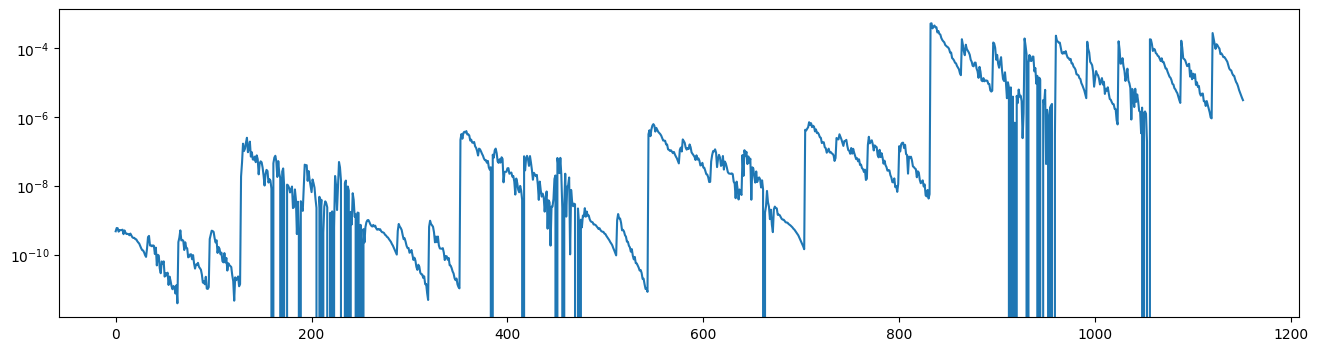

In [9]:
fig, ax = plt.subplots(figsize=(16,4))

ax.plot(cls)
ax.set(yscale="log")